In [2]:
# modules required for handling dataframes
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
from decimal import Decimal

In [3]:
# Define some global variables.
sourcedir = '/home/yiheng/MinION_data/' # the directory where all the documents of each sequencing run are stored.
basedir = os.path.join(sourcedir, 'mock_com', 'nanopore','amplicon')
genera_in_mock = ['Aspergillus','Blastobotrys','Candida','Diutina', 'Nakaseomyces', 'Clavispora','Cryptococcus','Cyberlindnera',
'Debaryomyces','Geotrichum','Kluyveromyces','Kodamaea','Lomentospora','Magnusiomyces','Meyerozyma','Pichia',
'Rhodotorula','Scedosporium','Trichophyton', 'Trichosporon', 'Wickerhamomyces','Yarrowia','Zygoascus', 'Purpureocillium']

In [4]:
# There are quite few if conditions in the function. This is because the final dataframes (tab files) are not consistantly generated.
# This function set an example of how to deal with inconsistant dataframe.
# I could clean up the final tab file from each analysis because I generated those files,
# but this kind of conditions can be useful if the tab files were generated by others.
def get_tab_df(barcode, db, algorithm):
    if db == 'uniteITS' and algorithm == 'minimap':
        tab_file = os.path.join(basedir, 'barcode%s' % barcode, 'barcode%s.UNITEITSdb_%s.tab' % (barcode, algorithm))
    else:
        tab_file = os.path.join(basedir, 'barcode%s' % barcode, 'barcode%s.%sdb_%s.tab' % (barcode, db, algorithm))
        
    tab_df = pd.read_csv(tab_file, sep='\t', index_col=0)
    return tab_df

def calculate_precision_rate(barcode, algorithm, db):      
    tab_df = get_tab_df(barcode, db, algorithm)
    if algorithm == 'k2':
        tab_df_in_mock = tab_df[tab_df.genus_k2.isin(genera_in_mock)]
        # Note that here I used number of reads instead of total length to calculate precision rate.
        # This is different with metagenomics dataset, and it is because this is the common way of doing it.
        # It is because amplicons are supposed to be the same length.
        precision_rate = len(tab_df_in_mock.read_id_k2)/len(tab_df.read_id_k2)
    else:
        tab_df_in_mock = tab_df[tab_df.genus.isin(genera_in_mock)]
        precision_rate = len(tab_df_in_mock.seqid)/len(tab_df.seqid)
    return precision_rate   

# Here is the function to calculate recall rate. ONLY FOR MINIMAP RESULT.
# This is because the kraken2 result is already shown in the kraken log record. Just need to note down the numbers.
def calculate_minimap_recall_rate(barcode, db):
    tab_df = get_tab_df(barcode, db, 'minimap')
    
    if barcode == '01':
        recall_rate = len(tab_df)/26212
    elif barcode == '02':
        recall_rate = len(tab_df)/20163
    elif barcode == '05':
        recall_rate = len(tab_df)/26680
    elif barcode == '06':
        recall_rate = len(tab_df)/18273
    elif barcode == '09':
        recall_rate = len(tab_df)/31826
    elif barcode == '10':
        recall_rate = len(tab_df)/15502
    else:
        print('barcode is wrong, please select another barcode.')
    return recall_rate

In [5]:
# Now make the recall rate dictionary for k2 analysis.
# These numbers are all copied straightway from the standard output of kraken analysis.
barcode_list = ['01','02','05','06','09','10']
recall_rate_list_ITS = [0.8852, 0.8466, 0.9445, 0.8285, 0.8730, 0.8096]
recall_rate_list_18S = [0.8730, 0.8311, 0.9348, 0.8191, 0.8647, 0.8030]
recall_rate_list_28S = [0.8672, 0.8136, 0.9265, 0.8022, 0.8585, 0.7854]
recall_rate_list_uniteITS = [0.8956, 0.8602, 0.9512, 0.8454, 0.8827, 0.8275]
recall_rate_list_unite99ITS = [0.8942, 0.8599, 0.9511, 0.8439, 0.8820, 0.8255]

k2_recall_dict_ITS = {key: value for (key, value) in zip(barcode_list, recall_rate_list_ITS)}
k2_recall_dict_18S = {key: value for (key, value) in zip(barcode_list, recall_rate_list_18S)}
k2_recall_dict_28S = {key: value for (key, value) in zip(barcode_list, recall_rate_list_28S)}
k2_recall_dict_uniteITS = {key: value for (key, value) in zip(barcode_list, recall_rate_list_uniteITS)}
k2_recall_dict_unite99ITS = {key: value for (key, value) in zip(barcode_list, recall_rate_list_unite99ITS)}

def get_k2_recall_rate(barcode, db):
    if db == 'ITS':
        recall_rate = k2_recall_dict_ITS[barcode]
        return recall_rate
    elif db == '18S':
        recall_rate = k2_recall_dict_18S[barcode]
        return recall_rate
    elif db == '28S':
        recall_rate = k2_recall_dict_28S[barcode]
        return recall_rate
    elif db == 'uniteITS':
        recall_rate = k2_recall_dict_uniteITS[barcode]
        return recall_rate
    elif db == 'unite99ITS':
        recall_rate = k2_recall_dict_unite99ITS[barcode]
        return recall_rate
    else:
        print("No analysis has been done for this database. Please change database name within 'ITS', '18S', '28S', 'uniteITS'")

In [6]:
def calculate_average_precision(sample, algorithm, db):
    if sample == 'IE':
        average_precision_rate = (calculate_precision_rate('01', '%s' % algorithm, '%s' % db) + 
                                  calculate_precision_rate('05', '%s' % algorithm, '%s' % db) + 
                                  calculate_precision_rate('09', '%s' % algorithm, '%s' % db))/3
        return average_precision_rate
    elif sample == 'MC':
        average_precision_rate = (calculate_precision_rate('02', '%s' % algorithm, '%s' % db) + 
                                  calculate_precision_rate('06', '%s' % algorithm, '%s' % db) + 
                                  calculate_precision_rate('10', '%s' % algorithm, '%s' % db))/3
        return average_precision_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")
        
def calculate_average_precision_all_algorithm(sample, db):
    if sample == 'IE' or sample == 'MC':
        average_precision_rate = (calculate_average_precision(sample, 'minimap', db) + calculate_average_precision(sample, 'k2', db))/2
        return average_precision_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")

In [7]:
# These recall calculation are all for classification rate, since I was misunderstood the recall rate so I name them all wrongly.
def calculate_average_recall_minimap(sample, db):
    if sample == 'IE':
        average_recall_rate = (calculate_minimap_recall_rate('01', '%s' % db) +
                                  calculate_minimap_recall_rate('05', '%s' % db) +
                                  calculate_minimap_recall_rate('09', '%s' % db))/3
        return average_recall_rate
    elif sample == 'MC':
        average_recall_rate = (calculate_minimap_recall_rate('02', '%s' % db) + 
                                  calculate_minimap_recall_rate('06', '%s' % db) + 
                                  calculate_minimap_recall_rate('10', '%s' % db))/3
        return average_recall_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")

def calculate_average_recall_k2(sample, db):
    if sample == 'IE':
        average_recall_rate = (get_k2_recall_rate('01', '%s' % db) +
                               get_k2_recall_rate('05', '%s' % db) +
                               get_k2_recall_rate('09', '%s' % db))/3
        return average_recall_rate
    elif sample == 'MC':
        average_recall_rate = (get_k2_recall_rate('02', '%s' % db) +
                               get_k2_recall_rate('06', '%s' % db) +
                               get_k2_recall_rate('10', '%s' % db))/3
        return average_recall_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")
        
def calculate_average_recall_all_algorithm(sample, db):
    if sample == 'IE' or sample == 'MC':
        average_recall_rate = (calculate_average_recall_k2(sample, db) + calculate_average_recall_minimap(sample, db))/2
        return average_recall_rate
    else:
        print("Please select sample name between 'IE' and 'MC'")

In [8]:
barcodes_IE = ['01', '05', '09']
barcodes_MC = ['02', '06', '10']
algorithms = ['minimap', 'k2']
db_list = ['ITS', 'unite99ITS', '18S', '28S']

In [9]:
precision_rate_list_IE = []
for x in itertools.product(algorithms, db_list, barcodes_IE):
    precision_rate_list_IE.append(calculate_precision_rate(x[2], x[0], x[1]))

In [10]:
precision_rate_list_MC = []
for x in itertools.product(algorithms, db_list, barcodes_MC):
    precision_rate_list_MC.append(calculate_precision_rate(x[2], x[0], x[1]))

In [11]:
minimap_recall_rate_list_IE = []
for x in itertools.product(db_list, barcodes_IE):
    minimap_recall_rate_list_IE.append(calculate_minimap_recall_rate(x[1], x[0]))
minimap_recall_rate_list_MC = []
for x in itertools.product(db_list, barcodes_MC):
    minimap_recall_rate_list_MC.append(calculate_minimap_recall_rate(x[1], x[0]))

In [12]:
k2_recall_rate_list_IE = []
for x in itertools.product(db_list, barcodes_IE):
    k2_recall_rate_list_IE.append(get_k2_recall_rate(x[1], x[0]))

k2_recall_rate_list_MC = []
for x in itertools.product(db_list, barcodes_MC):
    k2_recall_rate_list_MC.append(get_k2_recall_rate(x[1], x[0]))

In [13]:
recall_rate_list_IE = minimap_recall_rate_list_IE + k2_recall_rate_list_IE
recall_rate_list_MC = minimap_recall_rate_list_MC + k2_recall_rate_list_MC

In [14]:
precision_recall_df_IE = pd.DataFrame()
precision_recall_df_IE['precision'] = precision_rate_list_IE
precision_recall_df_IE['recall'] = recall_rate_list_IE
precision_recall_df_MC = pd.DataFrame()
precision_recall_df_MC['precision'] = precision_rate_list_MC
precision_recall_df_MC['recall'] = recall_rate_list_MC
precision_recall_df_IE['precision'] = precision_recall_df_IE['precision']*100
precision_recall_df_IE['recall'] = precision_recall_df_IE['recall']*100
precision_recall_df_MC['precision'] = precision_recall_df_MC['precision']*100
precision_recall_df_MC['recall'] = precision_recall_df_MC['recall']*100

precision_recall_df_IE['Database'] = 'ncbiITS'
precision_recall_df_IE['Algorithm'] = 'minimap2'
precision_recall_df_MC['Database'] = 'ncbiITS'
precision_recall_df_MC['Algorithm'] = 'minimap2'

In [15]:
precision_recall_df_IE.iloc[3:6,2:3] = 'uniteITS'
precision_recall_df_IE.iloc[6:9,2:3] = '18S'
precision_recall_df_IE.iloc[9:12,2:3] = '28S'
precision_recall_df_IE.iloc[12:15,2:3] = 'ncbiITS'
precision_recall_df_IE.iloc[15:18,2:3] = 'uniteITS'
precision_recall_df_IE.iloc[18:21,2:3] = '18S'
precision_recall_df_IE.iloc[21:24,2:3] = '28S'
precision_recall_df_MC.iloc[3:6,2:3] = 'uniteITS'
precision_recall_df_MC.iloc[6:9,2:3] = '18S'
precision_recall_df_MC.iloc[9:12,2:3] = '28S'
precision_recall_df_MC.iloc[12:15,2:3] = 'ncbiITS'
precision_recall_df_MC.iloc[15:18,2:3] = 'uniteITS'
precision_recall_df_MC.iloc[18:21,2:3] = '18S'
precision_recall_df_MC.iloc[21:24,2:3] = '28S'


precision_recall_df_IE.iloc[12:24,3:4] = 'kraken2'
precision_recall_df_MC.iloc[12:24,3:4] = 'kraken2'

In [16]:
# This is the calculation of the actual recall, which I named recall_1
precision_recall_df_MC['recall_1'] = precision_recall_df_MC.recall*precision_recall_df_MC.precision/100
precision_recall_df_IE['recall_1'] = precision_recall_df_IE.recall*precision_recall_df_IE.precision/100

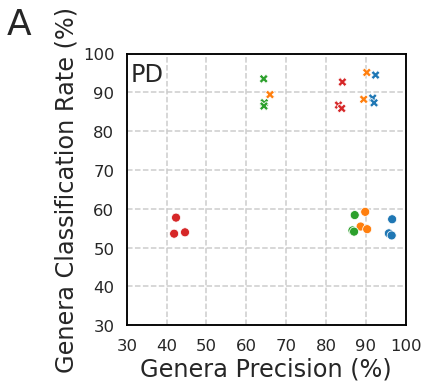

In [21]:
g, axes = plt.subplots(ncols=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context('talk')


g1 = sns.scatterplot(data=precision_recall_df_IE, x="precision", y="recall", 
                     hue="Database", palette='tab10', style="Algorithm")
g1.set(xlim=(30,100))
g1.set(ylim=(30,100))
g1.set_xticks(np.arange(30,105,10))
g1.set_yticks(np.arange(30,105,10))
g1.set_xlabel("Genera Precision (%)",fontsize=24)
g1.set_ylabel("Genera Classification Rate (%)",fontsize=24)
#axes.legend(fontsize=14, bbox_to_anchor=(1.1, 0.7))
plt.rcParams["figure.figsize"] = (5,5)
axes.get_legend().set_visible(False)
axes.spines['left'].set_color('k')
axes.spines['bottom'].set_color('k')
axes.spines['right'].set_color('k')
axes.spines['top'].set_color('k')
plt.rcParams["figure.figsize"] = (5,5)
axes.text(31, 93, 'PD', fontweight=300, fontsize=24)
axes.text(0, 105, 'A', fontweight=300, fontsize=36)
plt.savefig(os.path.join(basedir, 'Figure4A_1.png'), bbox_inches='tight', dpi=1000)
plt.show()

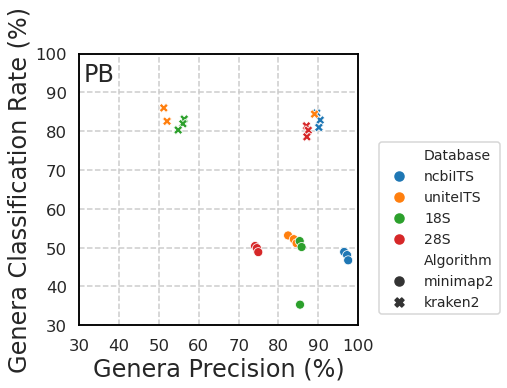

In [22]:
g, axes = plt.subplots(ncols=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context('talk')


g1 = sns.scatterplot(data=precision_recall_df_MC, x="precision", y="recall", 
                     hue="Database", palette='tab10', style="Algorithm")
g1.set(xlim=(30,100))
g1.set(ylim=(30,100))
g1.set_xticks(np.arange(30,105,10))
g1.set_xlabel("Genera Precision (%)",fontsize=24)
g1.set_ylabel("Genera Classification Rate (%)",fontsize=24)
axes.legend(fontsize=14, bbox_to_anchor=(1.05, 0.7))
#axes.get_legend().set_visible(False)
axes.spines['left'].set_color('k')
axes.spines['bottom'].set_color('k')
axes.spines['right'].set_color('k')
axes.spines['top'].set_color('k')
axes.text(31, 93, 'PB', fontweight=300, fontsize=24)
plt.savefig(os.path.join(basedir, 'Figure4A_2.png'), bbox_inches='tight', dpi=1000)
plt.show()

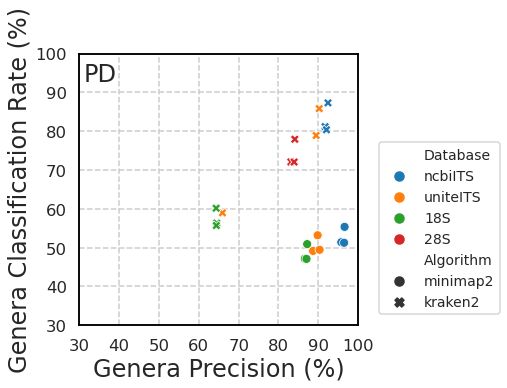

In [26]:
g, axes = plt.subplots(ncols=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context('talk')


g1 = sns.scatterplot(data=precision_recall_df_IE, x="precision", y="recall_1", 
                     hue="Database", palette='tab10', style="Algorithm")
g1.set(xlim=(30,100))
g1.set(ylim=(30,100))
g1.set_xticks(np.arange(30,105,10))
g1.set_xlabel("Genera Precision (%)",fontsize=24)
g1.set_ylabel("Genera Classification Rate (%)",fontsize=24)
axes.legend(fontsize=14, bbox_to_anchor=(1.05, 0.7))
#axes.get_legend().set_visible(False)
axes.spines['left'].set_color('k')
axes.spines['bottom'].set_color('k')
axes.spines['right'].set_color('k')
axes.spines['top'].set_color('k')
axes.text(31, 93, 'PD', fontweight=300, fontsize=24)
plt.savefig(os.path.join(basedir, 'Figure4A_recall_1.png'), bbox_inches='tight', dpi=1000)
plt.show()

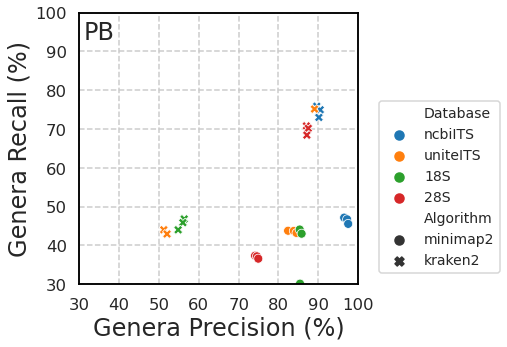

In [23]:
# To try to be consistent with other papers, I also plot the recall of the different classifications
g, axes = plt.subplots(ncols=1)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_context('talk')


g1 = sns.scatterplot(data=precision_recall_df_MC, x="precision", y="recall_1", 
                     hue="Database", palette='tab10', style="Algorithm")
g1.set(xlim=(30,100))
g1.set(ylim=(30,100))
g1.set_xticks(np.arange(30,105,10))
g1.set_xlabel("Genera Precision (%)",fontsize=24)
g1.set_ylabel("Genera Recall (%)",fontsize=24)
axes.legend(fontsize=14, bbox_to_anchor=(1.05, 0.7))
#axes.get_legend().set_visible(False)
axes.spines['left'].set_color('k')
axes.spines['bottom'].set_color('k')
axes.spines['right'].set_color('k')
axes.spines['top'].set_color('k')
axes.text(31, 93, 'PB', fontweight=300, fontsize=24)
plt.savefig(os.path.join(basedir, 'Figure4A_recall.png'), bbox_inches='tight', dpi=1000)
plt.show()